## 2D benchmark
To test the applicability of the developed pipeline, we create 2D Ackley function as follows: 

$$
f_{2D}(x,y)  = -a \exp\left(-b \sqrt{\frac{x^2 + y^2}{2}}\right) - \exp\left(\frac{\cos(cx) + \cos(cy)}{2}\right) + a + \exp(1)
$$

on $x,y:[-5,5]\times [-5,5]$. The interval is discretized into 200$\times$200 points and we assume  that no data is available for $x,y:[-0.5,-0.5]\times [-0.5,0.5] \cup [-0.5,0.5]\times [2.0,3.0] \cup [2.0,3.0]\times [2.0,3.0]$.  Then we use the devloepd pipeline to fit Fourier based functions on this masked data and reconstruct the whole data from it. 

### create test function (Ackley function)

In [1]:
import numpy as np

# create test fucntion
My = 201
Mz = 301
# number of points in y and z direction
y1d = np.linspace(-5, 5, My)  # 1D y-axis
z1d = np.linspace(-5, 5, Mz)  # 1D z-axis
y2d = np.tile(y1d, (len(z1d), 1))  # 2D y-axis
z2d = np.tile(z1d.reshape(len(z1d), 1), (1, len(y1d)))  # 2D z-axis


# the Ackley function
# parameters of the function
a = 5
b = 0.2
c = 1.5 * np.pi
# function calculation
u2d = (
    -a * np.exp(-b * np.sqrt((z2d**2 + y2d**2) / 2))
    - np.exp((np.cos(c * z2d) + np.cos(c * y2d)) / 2)
    + a
    + np.exp(1)
)
# normlaize the function between 0 and 1
u2d = (u2d - np.min(u2d)) / (np.max(u2d) - np.min(u2d))

# compute ky0 and kz0
ky = 2 * np.pi / (np.max(y1d) - np.min(y1d))
kz = 2 * np.pi / (np.max(z1d) - np.min(z1d))

# define N and padding, q (q=0.9 mean 10% extra padding)
Ny = 10
Nz = 11
q = 0.9

# define mask
mask2d = np.ones(u2d.shape)
mask2d[90:110, 90:110] = 0
mask2d[140:160, 140:160] = 0
mask2d[140:160, 90:110] = 0

# calcualte masked date
u2d_mask = u2d * mask2d

### Fourier decomposition and reconstruction

In [2]:
from mift.functions_2D import (
    efficient_unstructured_FFT_2D,
    efficient_unstructured_IFFT_2D,
)

# FFT decompoistion to compute [AA] and [BB] and [xx]
(A, b, coef) = efficient_unstructured_FFT_2D(
    u2d * mask2d, z1d, y1d, q * kz, q * ky, Nz, Ny, mask2d
)

# do IFFT to reconstruct the data in space domain
recon = efficient_unstructured_IFFT_2D(coef, z1d, y1d, q * kz, q * ky, Nz, Ny)

### Visualization

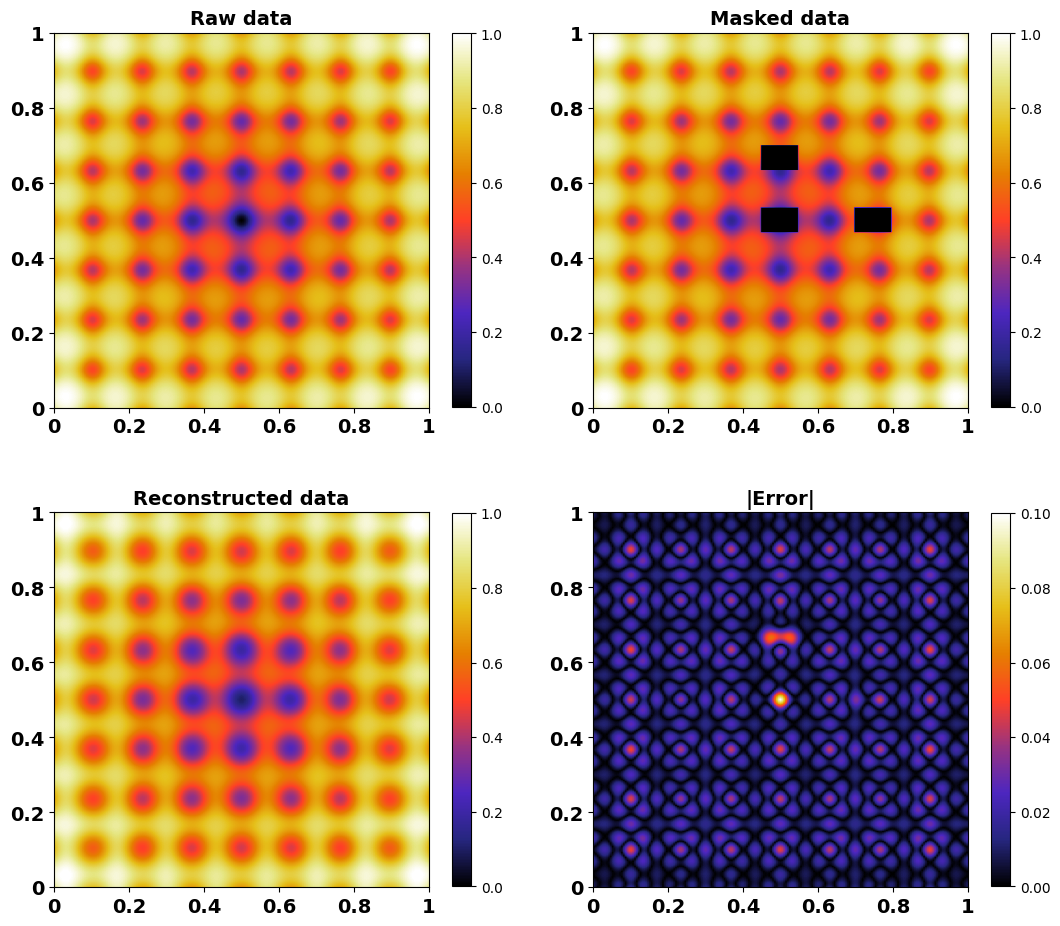

In [3]:
import matplotlib.pyplot as plt
from matplotlib import cm

fig, axes = plt.subplots(2, 2, figsize=(13, 12))
fig.subplots_adjust(wspace=0.15, hspace=0.08)
for i in range(4):
    if i == 0:
        ax = axes[0, 0]
        im = ax.imshow(u2d, extent=[0, 1, 0, 1], cmap=cm.CMRmap, vmin=0, vmax=1)
        ax.set_title("Raw data", fontsize=14, weight="bold")
        cbar = plt.colorbar(im, ax=ax, shrink=0.84)
    elif i == 1:
        ax = axes[0, 1]
        im = ax.imshow(u2d_mask, extent=[0, 1, 0, 1], cmap=cm.CMRmap, vmin=0, vmax=1)
        ax.set_title("Masked data", fontsize=14, weight="bold")
        cbar = plt.colorbar(im, ax=ax, shrink=0.84)
    elif i == 2:
        ax = axes[1, 0]
        im = ax.imshow(recon, extent=[0, 1, 0, 1], cmap=cm.CMRmap, vmin=0, vmax=1)
        ax.set_title("Reconstructed data", fontsize=14, weight="bold")
        cbar = plt.colorbar(im, ax=ax, shrink=0.84)
    else:
        ax = axes[1, 1]
        im = ax.imshow(
            np.abs(recon - u2d), extent=[0, 1, 0, 1], vmin=0, vmax=0.1, cmap=cm.CMRmap
        )
        ax.set_title("|Error|", fontsize=14, weight="bold")
        cbar = plt.colorbar(im, ax=ax, shrink=0.84)
    ax.set_xticks(
        ticks=[0, 0.2, 0.4, 0.6, 0.8, 1],
        labels=[0, 0.2, 0.4, 0.6, 0.8, 1],
        fontsize=14,
        weight="bold",
    )
    ax.set_yticks(
        ticks=[0, 0.2, 0.4, 0.6, 0.8, 1],
        labels=[0, 0.2, 0.4, 0.6, 0.8, 1],
        fontsize=14,
        weight="bold",
    )